# Perturb a single gene

## Import libraries

In [1]:
import cellplots as cp
import larry
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scdiffeq as sdq
import scdiffeq_analyses as sdq_an
import scipy.stats
import torch

## Get best ckpts

In [2]:
project_path = "./LightningSDE-FixedPotential-RegularizedVelocityRatio/"
project = sdq.io.Project(path = project_path)
best_ckpts = sdq_an.parsers.summarize_best_checkpoints(project)
best_ckpts

,train,test,ckpt_path,epoch
version_0,0.571656,0.551804,LightningSDE-FixedPotential-RegularizedVelocit...,2500
version_1,0.541401,0.465658,LightningSDE-FixedPotential-RegularizedVelocit...,1706
version_2,0.547771,0.499418,LightningSDE-FixedPotential-RegularizedVelocit...,1238
version_3,0.496815,0.504075,LightningSDE-FixedPotential-RegularizedVelocit...,1245
version_4,0.562102,0.522701,LightningSDE-FixedPotential-RegularizedVelocit...,1662


## Get data, PCA model

In [3]:
h5ad_path = "./adata.reprocessed_19OCT2023.more_feature_inclusive.h5ad"

adata = sdq.io.read_h5ad(h5ad_path)

AnnData object with n_obs × n_vars = 130887 × 2492
    obs: 'Library', 'Cell barcode', 'Time point', 'Starting population', 'Cell type annotation', 'Well', 'SPRING-x', 'SPRING-y', 'clone_idx', 'fate_observed', 't0_fated', 'train'
    var: 'gene_ids', 'hv_gene', 'must_include', 'exclude', 'use_genes'
    uns: 'fate_counts', 'h5ad_path', 'time_occupance'
    obsm: 'X_clone', 'X_pca', 'X_umap', 'cell_fate_df'
    layers: 'X_scaled'


In [4]:
PCA = sdq.io.read_pickle(path = "./pca_model.pkl")

/Users/mvinyard/.anaconda3/envs/scdiffeq/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PCA from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Run perturbation scan using the five best model checkpoints

In [5]:
Perturbed = {}
for version, row in best_ckpts.iterrows():
    model = sdq.io.load_model(adata=adata, ckpt_path = row['ckpt_path'])
    result = sdq.tl.perturb_scan_z_range(
        adata = adata,
        model = model,
        seed = 0,
        N = 2000,
        t_sim = torch.linspace(2, 6, 41),
        obs_key = "Cell type annotation",
        subset_key = "Cell type annotation",
        subset_val = "Undifferentiated",
        gene_id_key = "gene_ids",
        genes = ['Spi1'],
        PCA = PCA,
        z_range = np.linspace(-10, 10, 9)
    )
    Perturbed[version] = result

 - [INFO] | Input data configured.
 - [INFO] | Bulding Annoy kNN Graph on adata.obsm['train']


Seed set to 0


 - [INFO] | Using the specified parameters, LightningSDE-FixedPotential-RegularizedVelocityRatio has been called.
 - [INFO] | Input data configured.
 - [INFO] | Bulding Annoy kNN Graph on adata.obsm['train']


Seed set to 0


 - [INFO] | Using the specified parameters, LightningSDE-FixedPotential-RegularizedVelocityRatio has been called.
 - [INFO] | Input data configured.
 - [INFO] | Bulding Annoy kNN Graph on adata.obsm['train']


Seed set to 0


 - [INFO] | Using the specified parameters, LightningSDE-FixedPotential-RegularizedVelocityRatio has been called.
 - [INFO] | Input data configured.
 - [INFO] | Bulding Annoy kNN Graph on adata.obsm['train']


Seed set to 0


 - [INFO] | Using the specified parameters, LightningSDE-FixedPotential-RegularizedVelocityRatio has been called.
 - [INFO] | Input data configured.
 - [INFO] | Bulding Annoy kNN Graph on adata.obsm['train']


Seed set to 0


 - [INFO] | Using the specified parameters, LightningSDE-FixedPotential-RegularizedVelocityRatio has been called.


In [6]:
sdq.io.write_pickle(obj = Perturbed, path = "Spi1.perturb.z_scan.pkl")

---

In [2]:
Perturbed = sdq.io.read_pickle("./Spi1.perturb.z_scan.pkl")

In [3]:
fates = ['Neutrophil', 'Monocyte', 'Baso']
PlotVals = {}
for version, result in Perturbed.items():
    PlotVals[version] = {}
    for fate in fates:
        fate_df = pd.DataFrame({z: result.stats.T[fate] for z, result in result.items()}).T
        PlotVals[version][fate] = list(fate_df['lfc'].values)


PlotValsReshaped = {}
for fate in fates:
    PlotValsReshaped[fate] = {i*4: list(row.values) for i, row in pd.DataFrame({k: v[fate] for k, v in PlotVals.items()}).iterrows()}

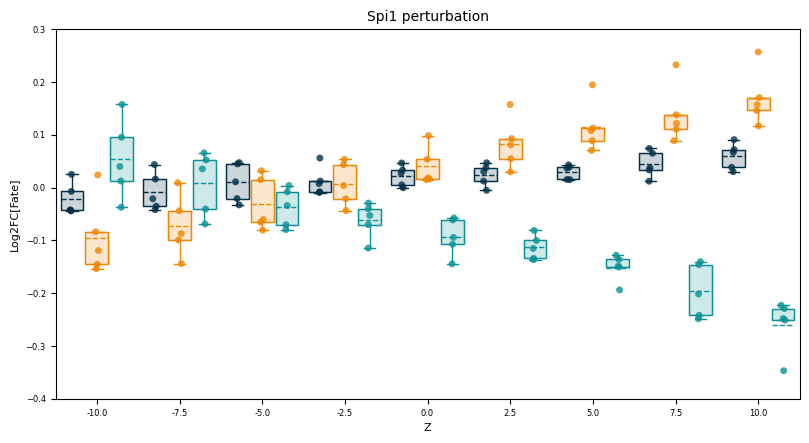

In [7]:
fig, axes = cp.plot(
    1, 1, height = 1, width = 1.5, x_label=["Z"], y_label=["Log2FC[Fate]"], title = ['Spi1 perturbation'],
)
axes[0].set_xlim(-1, 35)
axes[0].set_ylim(-0.4, 0.3)
larry_cmap = larry.pl.InVitroColorMap()._dict
x_offsets = [-1.2, 0, 1.2]
for en, fate in enumerate(fates):
    bpl = cp.core.box_plot(
        data = PlotValsReshaped[fate],
        ax = axes[0],
        colors=[larry_cmap[fate]]*len(PlotValsReshaped[fate]),
        x_offset=x_offsets[en],
        box_widths=1.1,
    )
xt = axes[0].set_xticks(np.arange(1, 37, 4), [str(i) for i in np.linspace(-10, 10, 9)])
plt.savefig("LARRY.Spi1_perturbation.z_scan.svg")

## Compute correlations

Annotate the **Figure 3J** with the results

In [5]:
x, y = {}, {}
for version, results in PlotVals.items():
    for fate, vals in results.items():
        if not fate in x:
            x[fate] = []
        if not fate in y:
            y[fate] = []
        _ = [x[fate].append(xi) for xi in np.linspace(-10, 10, 9).tolist()]
        _ = [y[fate].append(yi) for yi in vals]

In [6]:
for fate in fates:
    corr, pval = scipy.stats.pearsonr(x[fate], y[fate])
    print("{:<10} | corr: {:<6} [pval: {:.3e}]".format(fate, round(corr, 3), pval))

Neutrophil | corr: 0.684  [pval: 2.280e-07]
Monocyte   | corr: 0.883  [pval: 1.034e-15]
Baso       | corr: -0.906 [pval: 1.182e-17]
